Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

np.random.seed(42)


Synthetic Data Gen

In [2]:
n_samples = 1000

heart_rate_normal = np.random.normal(loc=70, scale=10, size=n_samples)
spo2_normal = np.random.normal(loc=97, scale=1, size=n_samples)
temp_normal = np.random.normal(loc=37.0, scale=0.5, size=n_samples)

df = pd.DataFrame({
    'heart_rate': np.random.normal(70, 10, 1000),
    'spo2': np.random.normal(97, 1, 1000),
    'temperature': np.random.normal(37.0, 0.5, 1000)
})

print("First 5 rows of the normal data:")
print(df.head())


First 5 rows of the normal data:
   heart_rate       spo2  temperature
0   50.921924  96.136506    36.788120
1   61.396150  96.968797    36.773293
2   65.863945  97.018017    36.102178
3   88.876877  97.472630    36.834955
4   75.565531  95.633142    37.366415


Anomaly injection

In [3]:

anomaly_rate = 0.05
n_anomalies = int(anomaly_rate * n_samples)

anomalous_indices = np.random.choice(df.index, n_anomalies, replace=False)

for idx in anomalous_indices:
    if np.random.rand() < 0.5:
        df.loc[idx, 'heart_rate'] = np.random.randint(120, 160)  # High HR
    else:
        df.loc[idx, 'heart_rate'] = np.random.randint(30, 50)    # Low HR
    
    df.loc[idx, 'spo2'] = np.random.randint(80, 90)
    
    df.loc[idx, 'temperature'] = np.random.uniform(38.5, 40.0)

print(f"Injected {n_anomalies} anomalies into the dataset.")


Injected 50 anomalies into the dataset.


anaomaly labels

In [4]:

df['true_label'] = 0
df.loc[anomalous_indices, 'true_label'] = 1  # Mark anomalies

print("Distribution of true labels:")
print(df['true_label'].value_counts())


Distribution of true labels:
true_label
0    950
1     50
Name: count, dtype: int64


Train an isolation forest model

In [5]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
iso_forest.fit(df[['heart_rate', 'spo2', 'temperature']])
print("Isolation Forest training complete.")

Isolation Forest training complete.


In [6]:
new_data = pd.DataFrame({
    'heart_rate': [72, 130, 45, 80, 68],
    'spo2': [97, 85, 89, 96, 98],
    'temperature': [37.2, 39.0, 38.8, 37.0, 36.9]
})

In [7]:
predictions = iso_forest.predict(new_data[['heart_rate', 'spo2', 'temperature']])
predictions = [1 if p == -1 else 0 for p in predictions]
print("Predictions (0=normal, 1=anomaly):", predictions)

Predictions (0=normal, 1=anomaly): [0, 1, 1, 0, 0]


detect anomalies

In [8]:

preds = iso_forest.predict(df[['heart_rate', 'spo2', 'temperature']])
df['model_pred'] = preds
df['model_pred'] = df['model_pred'].map({1: 0, -1: 1})

true_positives = ((df['model_pred'] == 1) & (df['true_label'] == 1)).sum()
false_positives = ((df['model_pred'] == 1) & (df['true_label'] == 0)).sum()
true_negatives = ((df['model_pred'] == 0) & (df['true_label'] == 0)).sum()
false_negatives = ((df['model_pred'] == 0) & (df['true_label'] == 1)).sum()

print("Model Results on the Training Data:")
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")


Model Results on the Training Data:
True Positives: 49
False Positives: 1
True Negatives: 949
False Negatives: 1


plot

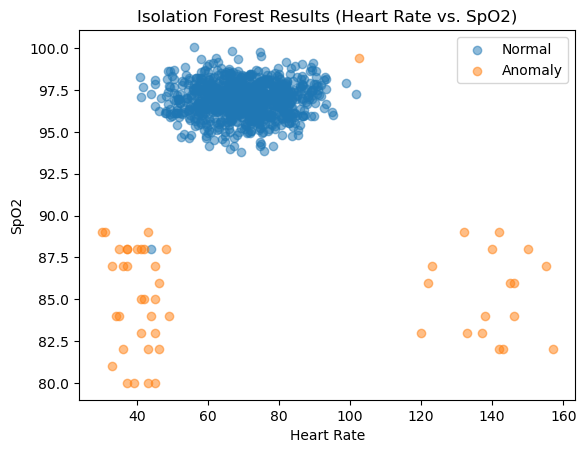

In [9]:

normal_points = df[df['model_pred'] == 0]
anomalies = df[df['model_pred'] == 1]

plt.scatter(
    normal_points['heart_rate'],
    normal_points['spo2'],
    label='Normal',
    alpha=0.5
)
plt.scatter(
    anomalies['heart_rate'],
    anomalies['spo2'],
    label='Anomaly',
    alpha=0.5
)

plt.xlabel("Heart Rate")
plt.ylabel("SpO2")
plt.title("Isolation Forest Results (Heart Rate vs. SpO2)")
plt.legend()
plt.show()


test on new data

In [10]:

new_data = pd.DataFrame({
    'heart_rate': [72, 130, 45, 80, 58],
    'spo2': [97, 85, 89, 76, 8],
    'temperature': [37.2, 39.0, 98.8, 37.0, 36.9]
})

print("New data sample:")
print(new_data)

# Predict anomalies
new_preds = iso_forest.predict(new_data)
new_preds = [1 if p == -1 else 0 for p in new_preds]  # 1=anomaly, 0=normal

for i, pred in enumerate(new_preds):
    print(f"Row {i}: {new_data.iloc[i].values} => {'Anomaly' if pred==1 else 'Normal'}")


New data sample:
   heart_rate  spo2  temperature
0          72    97         37.2
1         130    85         39.0
2          45    89         98.8
3          80    76         37.0
4          58     8         36.9
Row 0: [72.  97.  37.2] => Normal
Row 1: [130.  85.  39.] => Anomaly
Row 2: [45.  89.  98.8] => Anomaly
Row 3: [80. 76. 37.] => Anomaly
Row 4: [58.   8.  36.9] => Anomaly


another test

In [11]:

new_data = pd.DataFrame({
    'heart_rate': [72],
    'spo2': [97],
    'temperature': [38]
})

print("New data sample:")
print(new_data)

# Predict anomalies
new_preds = iso_forest.predict(new_data)
new_preds = [1 if p == -1 else 0 for p in new_preds]  # 1=anomaly, 0=normal

for i, pred in enumerate(new_preds):
    print(f"Row {i}: {new_data.iloc[i].values} => {'Anomaly' if pred==1 else 'Normal'}")


New data sample:
   heart_rate  spo2  temperature
0          72    97           38
Row 0: [72 97 38] => Normal


In [13]:
import joblib

# Save the trained model
joblib.dump(iso_forest, "isoforest.joblib")
print("✅ Model exported to 'isoforest.joblib'")


✅ Model exported to 'isoforest.joblib'
